In [1]:
import pandas as pd
import pymc3 as pm
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Section 16.1

                 Score           
                  mean        std
Group                            
Placebo     100.035088  17.894497
Smart Drug  107.841270  25.445201


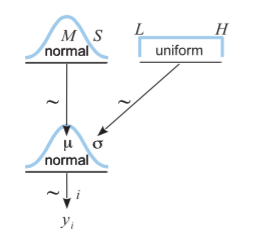

In [2]:
data = pd.read_csv("data/TwoGroupIQ.csv", dtype={'Group':'category'})
smart_drug = data[data["Group"] == "Smart Drug"]
placebo = data[data["Group"] == "Placebo"]
print(data.groupby("Group").agg(["mean", "std"]))
Image("images/fig16_2.png")

In [3]:
with pm.Model() as model16_1:
    obs_sd = smart_drug["Score"].std()
    mu = pm.Normal("mu", mu=smart_drug["Score"].mean(), sd=obs_sd*100)
    sd = pm.Uniform("sd", obs_sd / 1000, obs_sd * 1000)
    obs = pm.Normal("obs", mu=mu,sd=sd, observed=smart_drug["Score"])
    
    normal_traces = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:14<00:00, 1452.92draws/s]


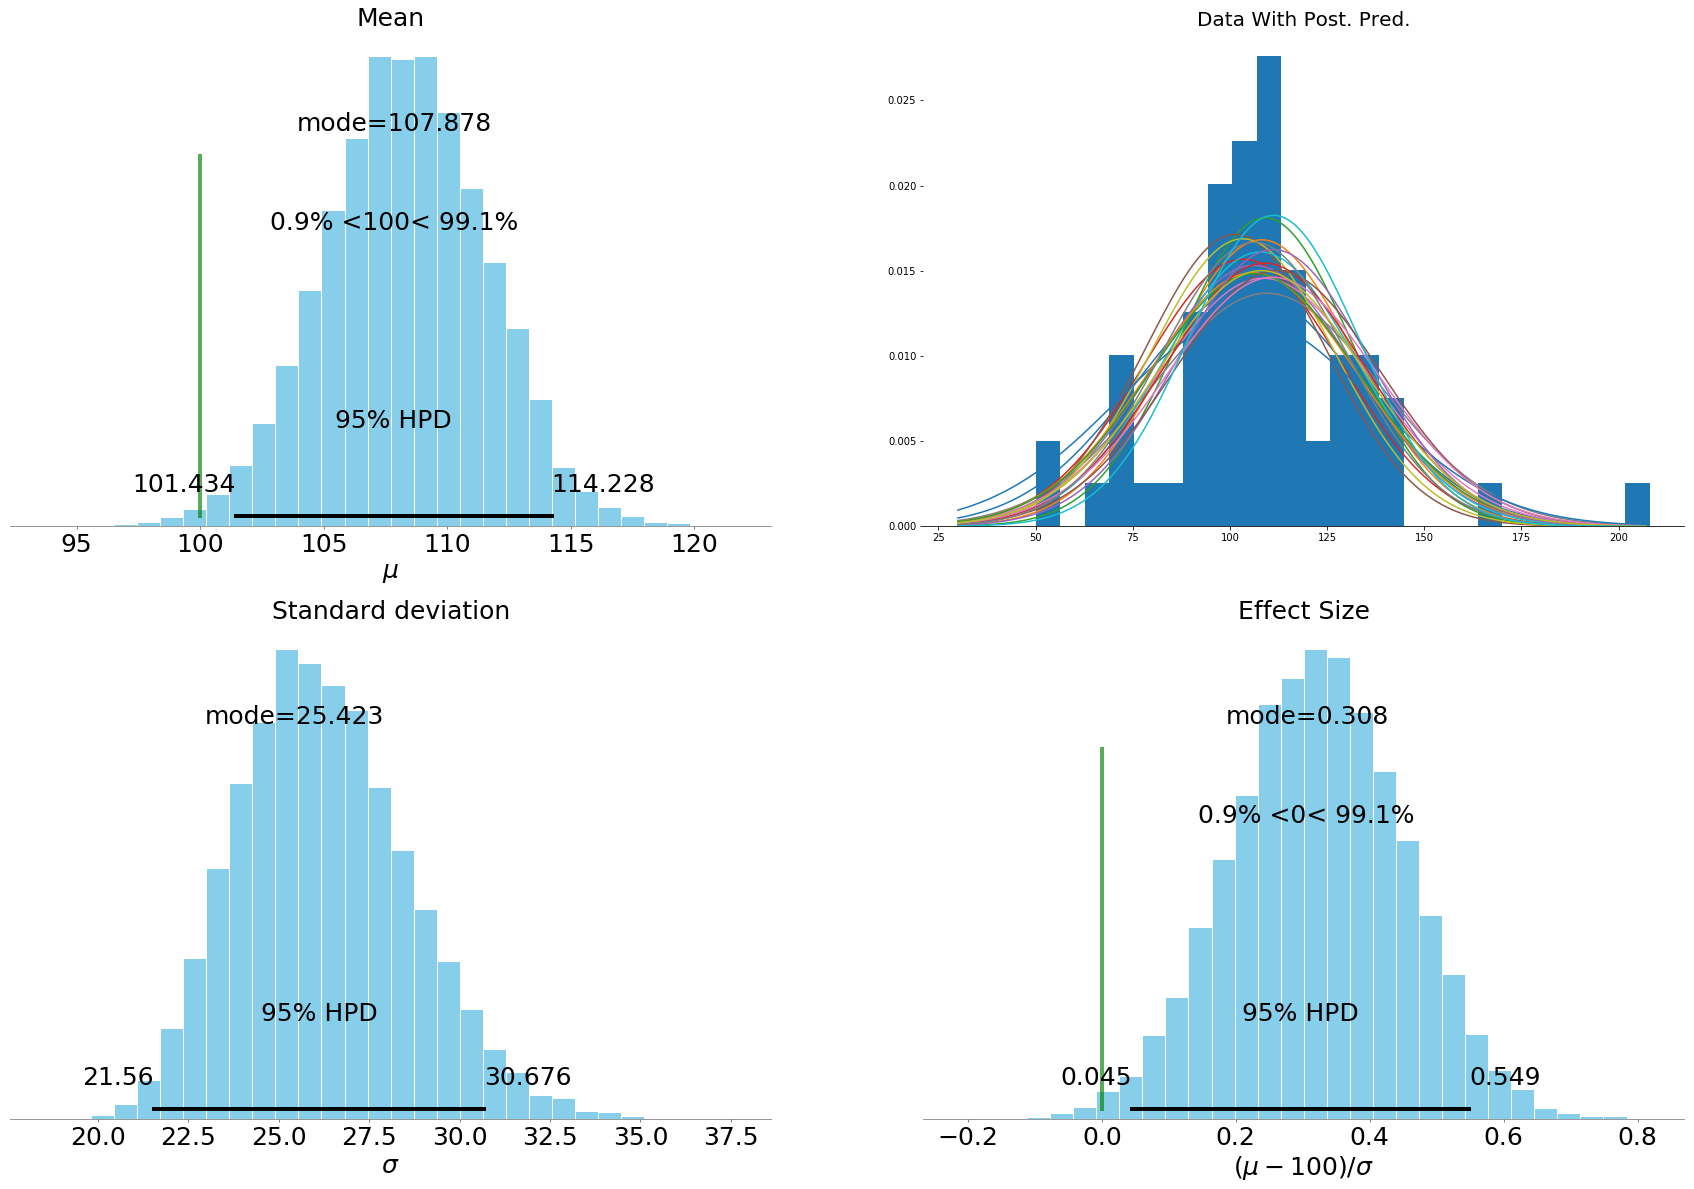

In [13]:
burned_normal_trace = normal_traces[500:]
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, figsize=(30,20))

#Posterior Mean
plot_posterior("Mean", '$\mu$', ax1, burned_normal_trace['mu'], ref_value=100)

#Data with credible posterior mu's and std's superimposed - posterior predictive check
posterior_predictive_check(20, ax2, burned_normal_trace['mu'], burned_normal_trace['sd'], 'Data With Post. Pred.', data['Score'][data['Group'] == 'Smart Drug'])

#bottom left Plot standard deviation posterior
plot_posterior("Standard deviation", "$\sigma$", ax3, burned_normal_trace["sd"])

#bottom right, effect size posterior
plot_posterior("Effect Size", '$(\mu - 100)/\sigma$',  ax4, (burned_normal_trace['mu']-100)/burned_normal_trace['sd'], ref_value=0 )

## Takeaways
* _Effect Size_: Standardized(by standard deviation) change induced by the treatment

## 16.2: Outliers and Robust Estimation, the StudentT distribution

In [14]:
with pm.Model() as model16_1:
    obs_sd = smart_drug["Score"].std()
    mu = pm.Normal("mu", mu=smart_drug["Score"].mean(), sd=obs_sd*100)
    sd = pm.Uniform("sd", obs_sd / 1000, obs_sd * 1000)
    nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29)
    nu = pm.Deterministic("nu", nu_minus_one + 1)
    obs = pm.StudentT("obs", mu=mu,sd=sd, nu=nu, observed=smart_drug["Score"])
    
    traces = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_minus_one, sd, mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:26<00:00, 781.52draws/s] 
The acceptance probability does not match the target. It is 0.8909674848250859, but should be close to 0.8. Try to increase the number of tuning steps.


In [15]:
pm.summary(traces)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,107.167440,2.829102,0.029080,101.361846,112.507875,11545.878741,1.000015
sd,19.835194,3.504945,0.034444,13.234191,26.760002,10100.740905,0.999952
nu_minus_one,8.732737,12.917694,0.132829,0.054396,30.829923,10522.602510,0.999978
nu,9.732737,12.917694,0.132829,1.054396,31.829923,10522.602510,0.999978


Text(0,0.5,'Mean $m$')

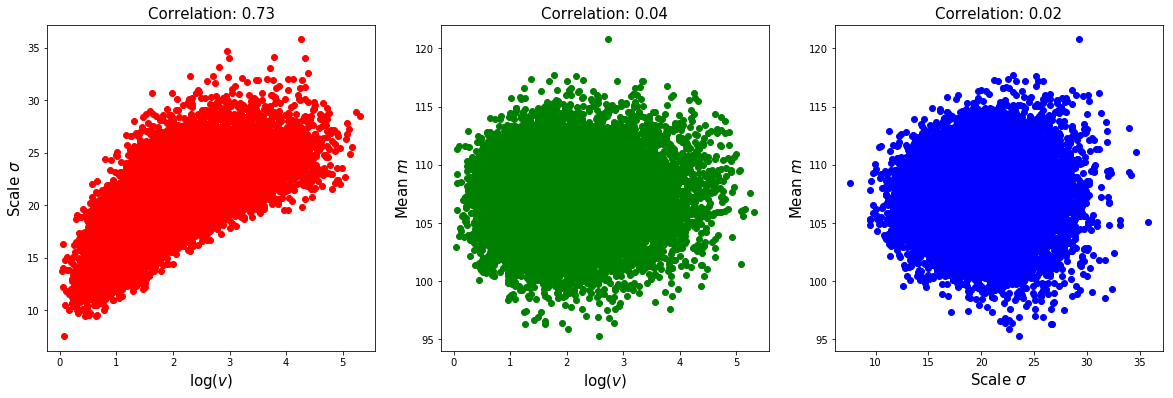

In [16]:
font = { 'size'   : 15}
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))
nu, sd = np.log(traces['nu']), traces['sd']
ax1.plot(nu, sd, 'ro')
corr_coeff = np.corrcoef(nu, sd).round(2)

ax1.set_title("Correlation: {}".format(corr_coeff[1][0]), font)
ax1.set_xlabel("log($v$)", font)
ax1.set_ylabel("Scale $\sigma$", font)

corr_coeff_2 = np.corrcoef(np.log(traces['nu']), traces['mu']).round(2)
ax2.plot(np.log(traces['nu']), traces['mu'], 'go')
ax2.set_title("Correlation: {}".format(corr_coeff_2[1][0]), font)
ax2.set_xlabel("log($v$)", font)
ax2.set_ylabel("Mean $m$", font)

corr_coeff_3 = np.corrcoef(traces['sd'], traces['mu']).round(2)
ax3.plot(traces['sd'], traces['mu'], 'bo')
ax3.set_title("Correlation: {}".format(corr_coeff_3[1][0]), font)
ax3.set_xlabel("Scale $\sigma$", font)
ax3.set_ylabel("Mean $m$", font)

### Key Points
* Correlation between _log(v)_ and $sigma$ are trademarks of outliers. Accomodation of outliers requires v to be small(heavy tails) or v to be large(close to Normal dist) with large sigma to include the data 

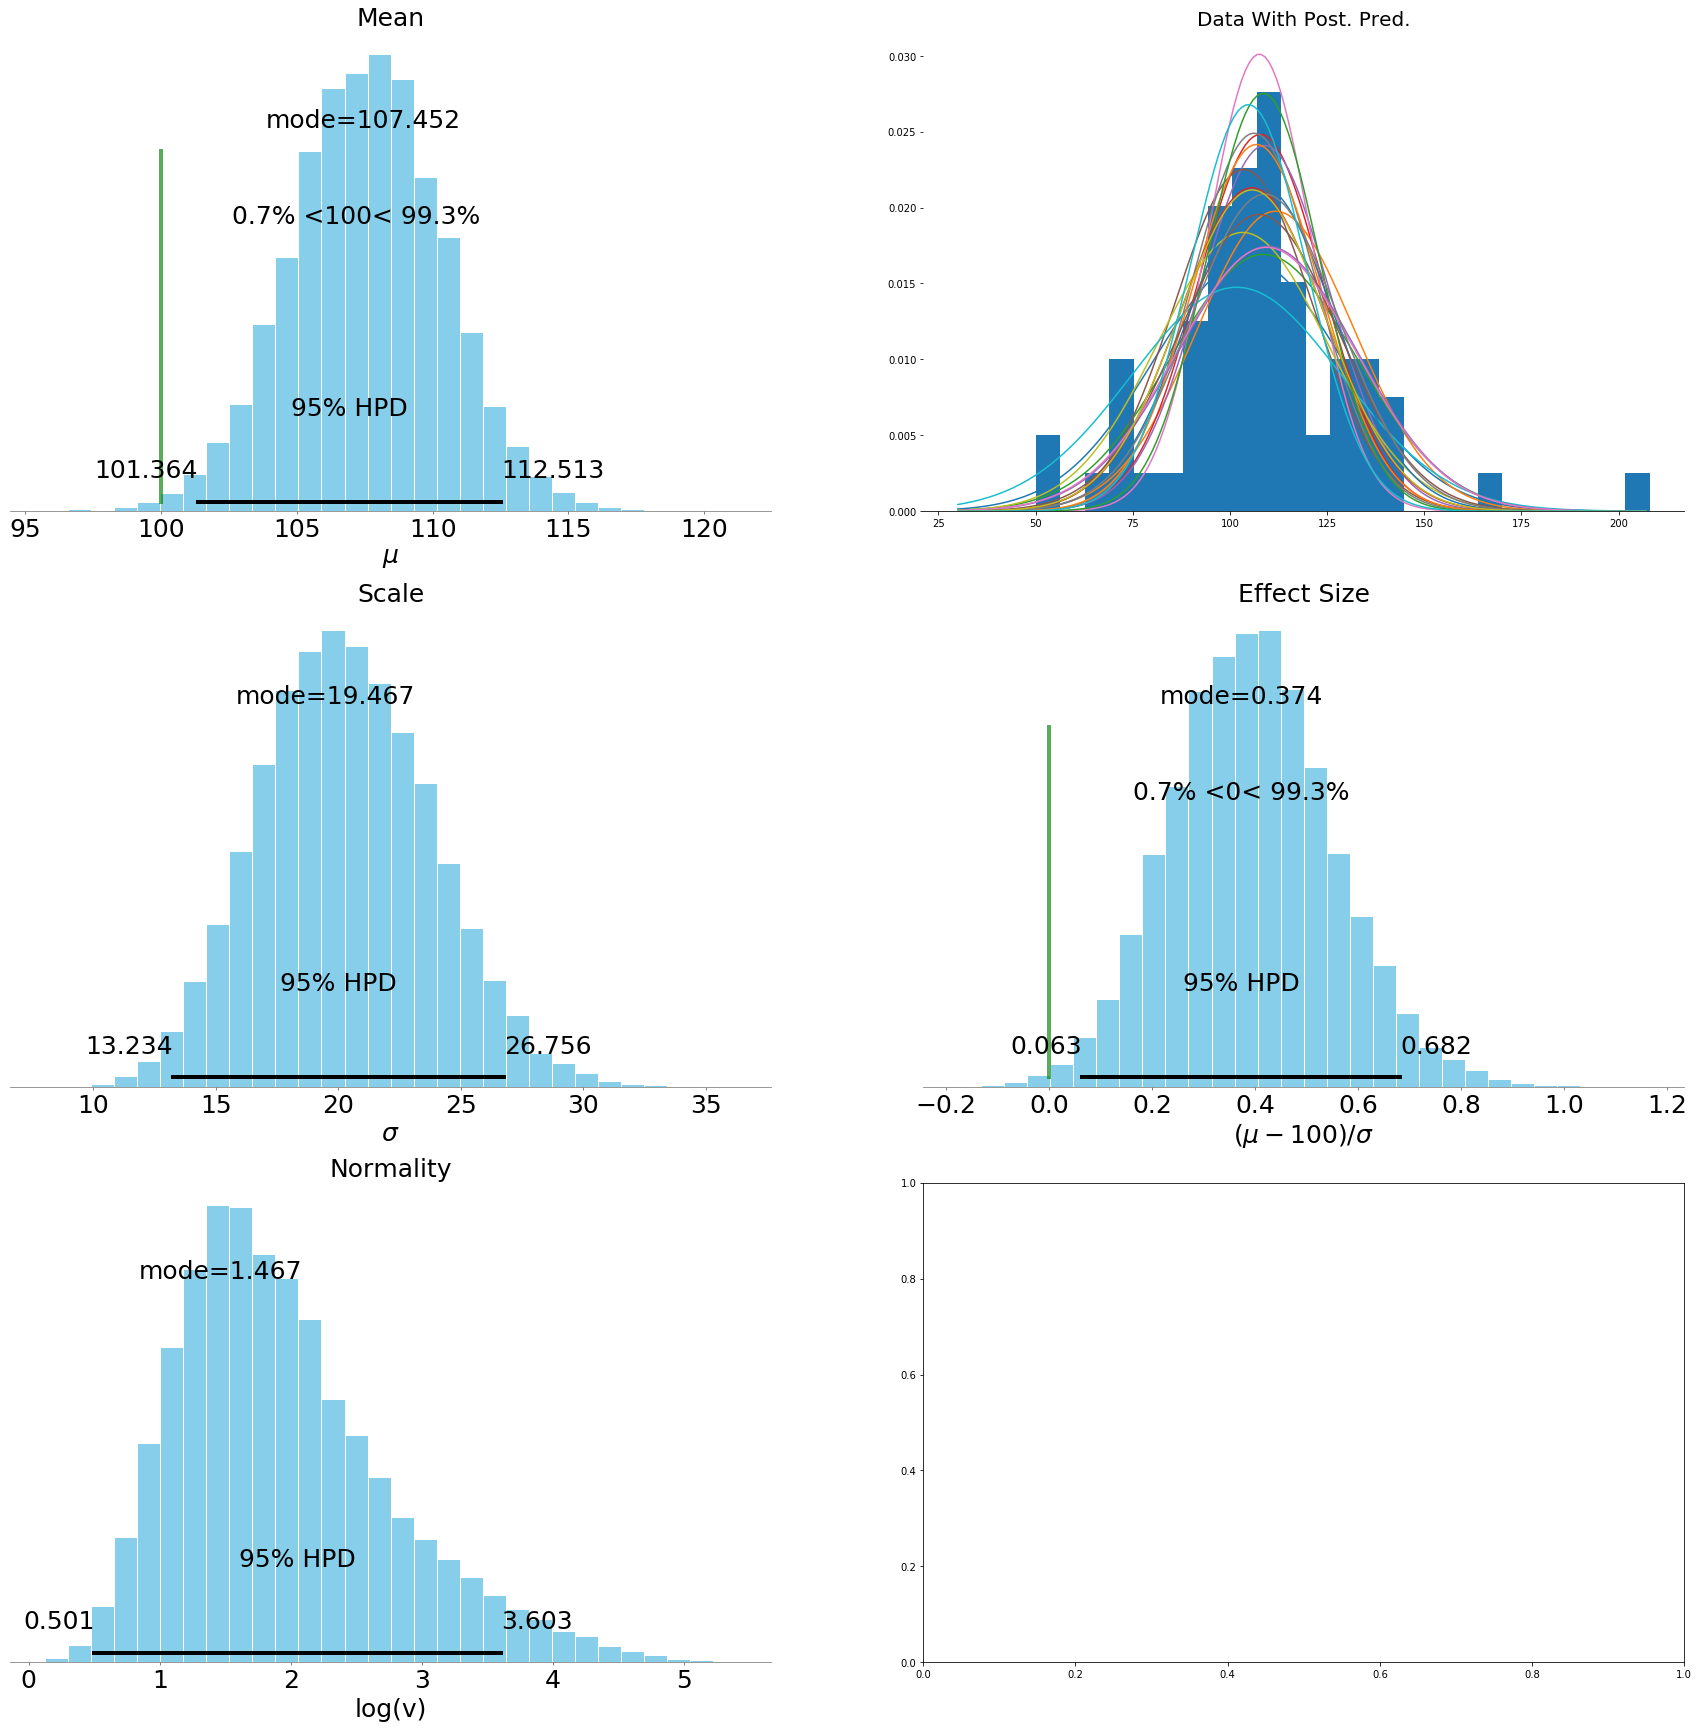

In [21]:
burned_trace = traces[20:]
fig, [(ax1, ax2), (ax3, ax4), (ax5, ax6)] = plt.subplots(3,2, figsize=(30,30))

#Posterior Mean
plot_posterior("Mean", '$\mu$', ax1, burned_trace['mu'], ref_value=100)

#Data with credible posterior mu's and std's superimposed - posterior predictive check
posterior_predictive_check(20, ax2, burned_trace['mu'], burned_trace['sd'], 'Data With Post. Pred.', data['Score'][data['Group'] == 'Smart Drug'])

#middle left Plot standard deviation posterior
plot_posterior("Scale", "$\sigma$", ax3, burned_trace["sd"])

#middle right, effect size posterior
plot_posterior("Effect Size", '$(\mu - 100)/\sigma$',  ax4, (burned_trace['mu']-100)/burned_trace['sd'], ref_value=0 )


#bottom left, log(v) posterior
plot_posterior("Normality", 'log(v)',  ax5, np.log(burned_trace['nu']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123dd80b8>,
      dtype=object)

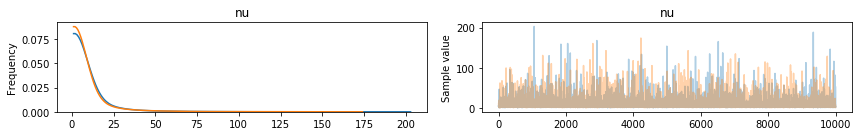

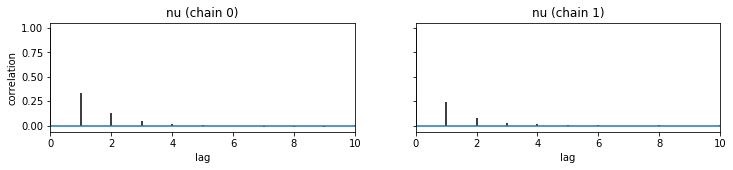

In [22]:
pm.traceplot(traces, varnames=['nu'])
pm.autocorrplot(traces, varnames=['nu'], max_lag=10)

### Key Points
* correlated nu and sigma values are the hallmark of data with outliers

## 16.3 Two Groups

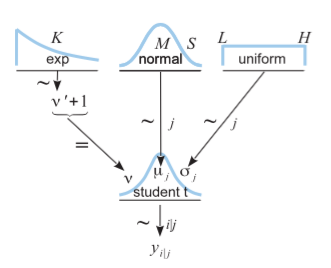

In [23]:
Image("images/fig16_11.png")

In [24]:
group_index = data.Group.cat.codes

In [25]:
with pm.Model() as model_16_3:
    obs_sd = data["Score"].std()
    obs_mu = data["Score"].mean()
    mus = pm.Normal("mus", mu=obs_mu, sd=obs_sd*100, shape=2)
    sds = pm.Uniform("sds", obs_sd / 1000, obs_sd * 1000, shape=2)
    nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29)
    nu = pm.Deterministic("nu", nu_minus_one + 1)
    pm.StudentT("likelihood", mu=mus[group_index],sd=sds[group_index], nu=nu, observed=data.Score.values)
    traces = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_minus_one, sds, mus]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:36<00:00, 575.05draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12563f278>,
      dtype=object)

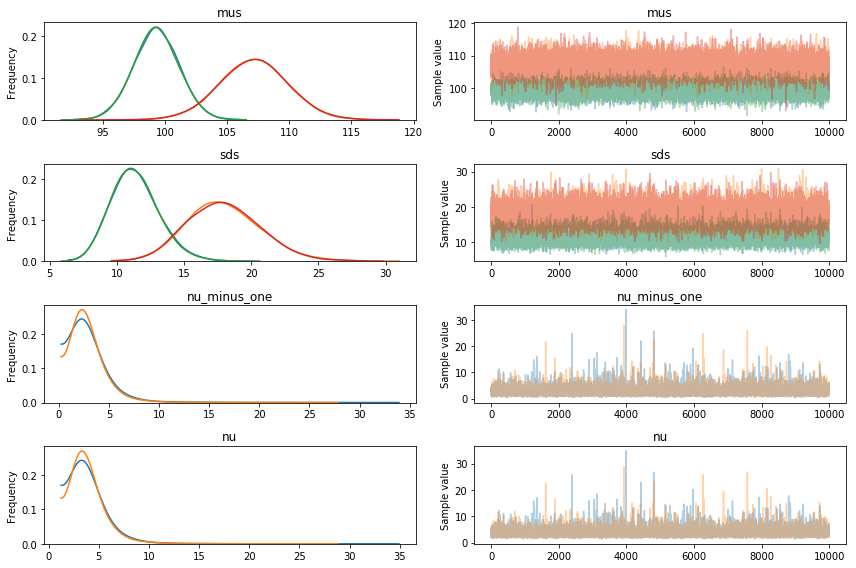

In [26]:
pm.traceplot(traces)

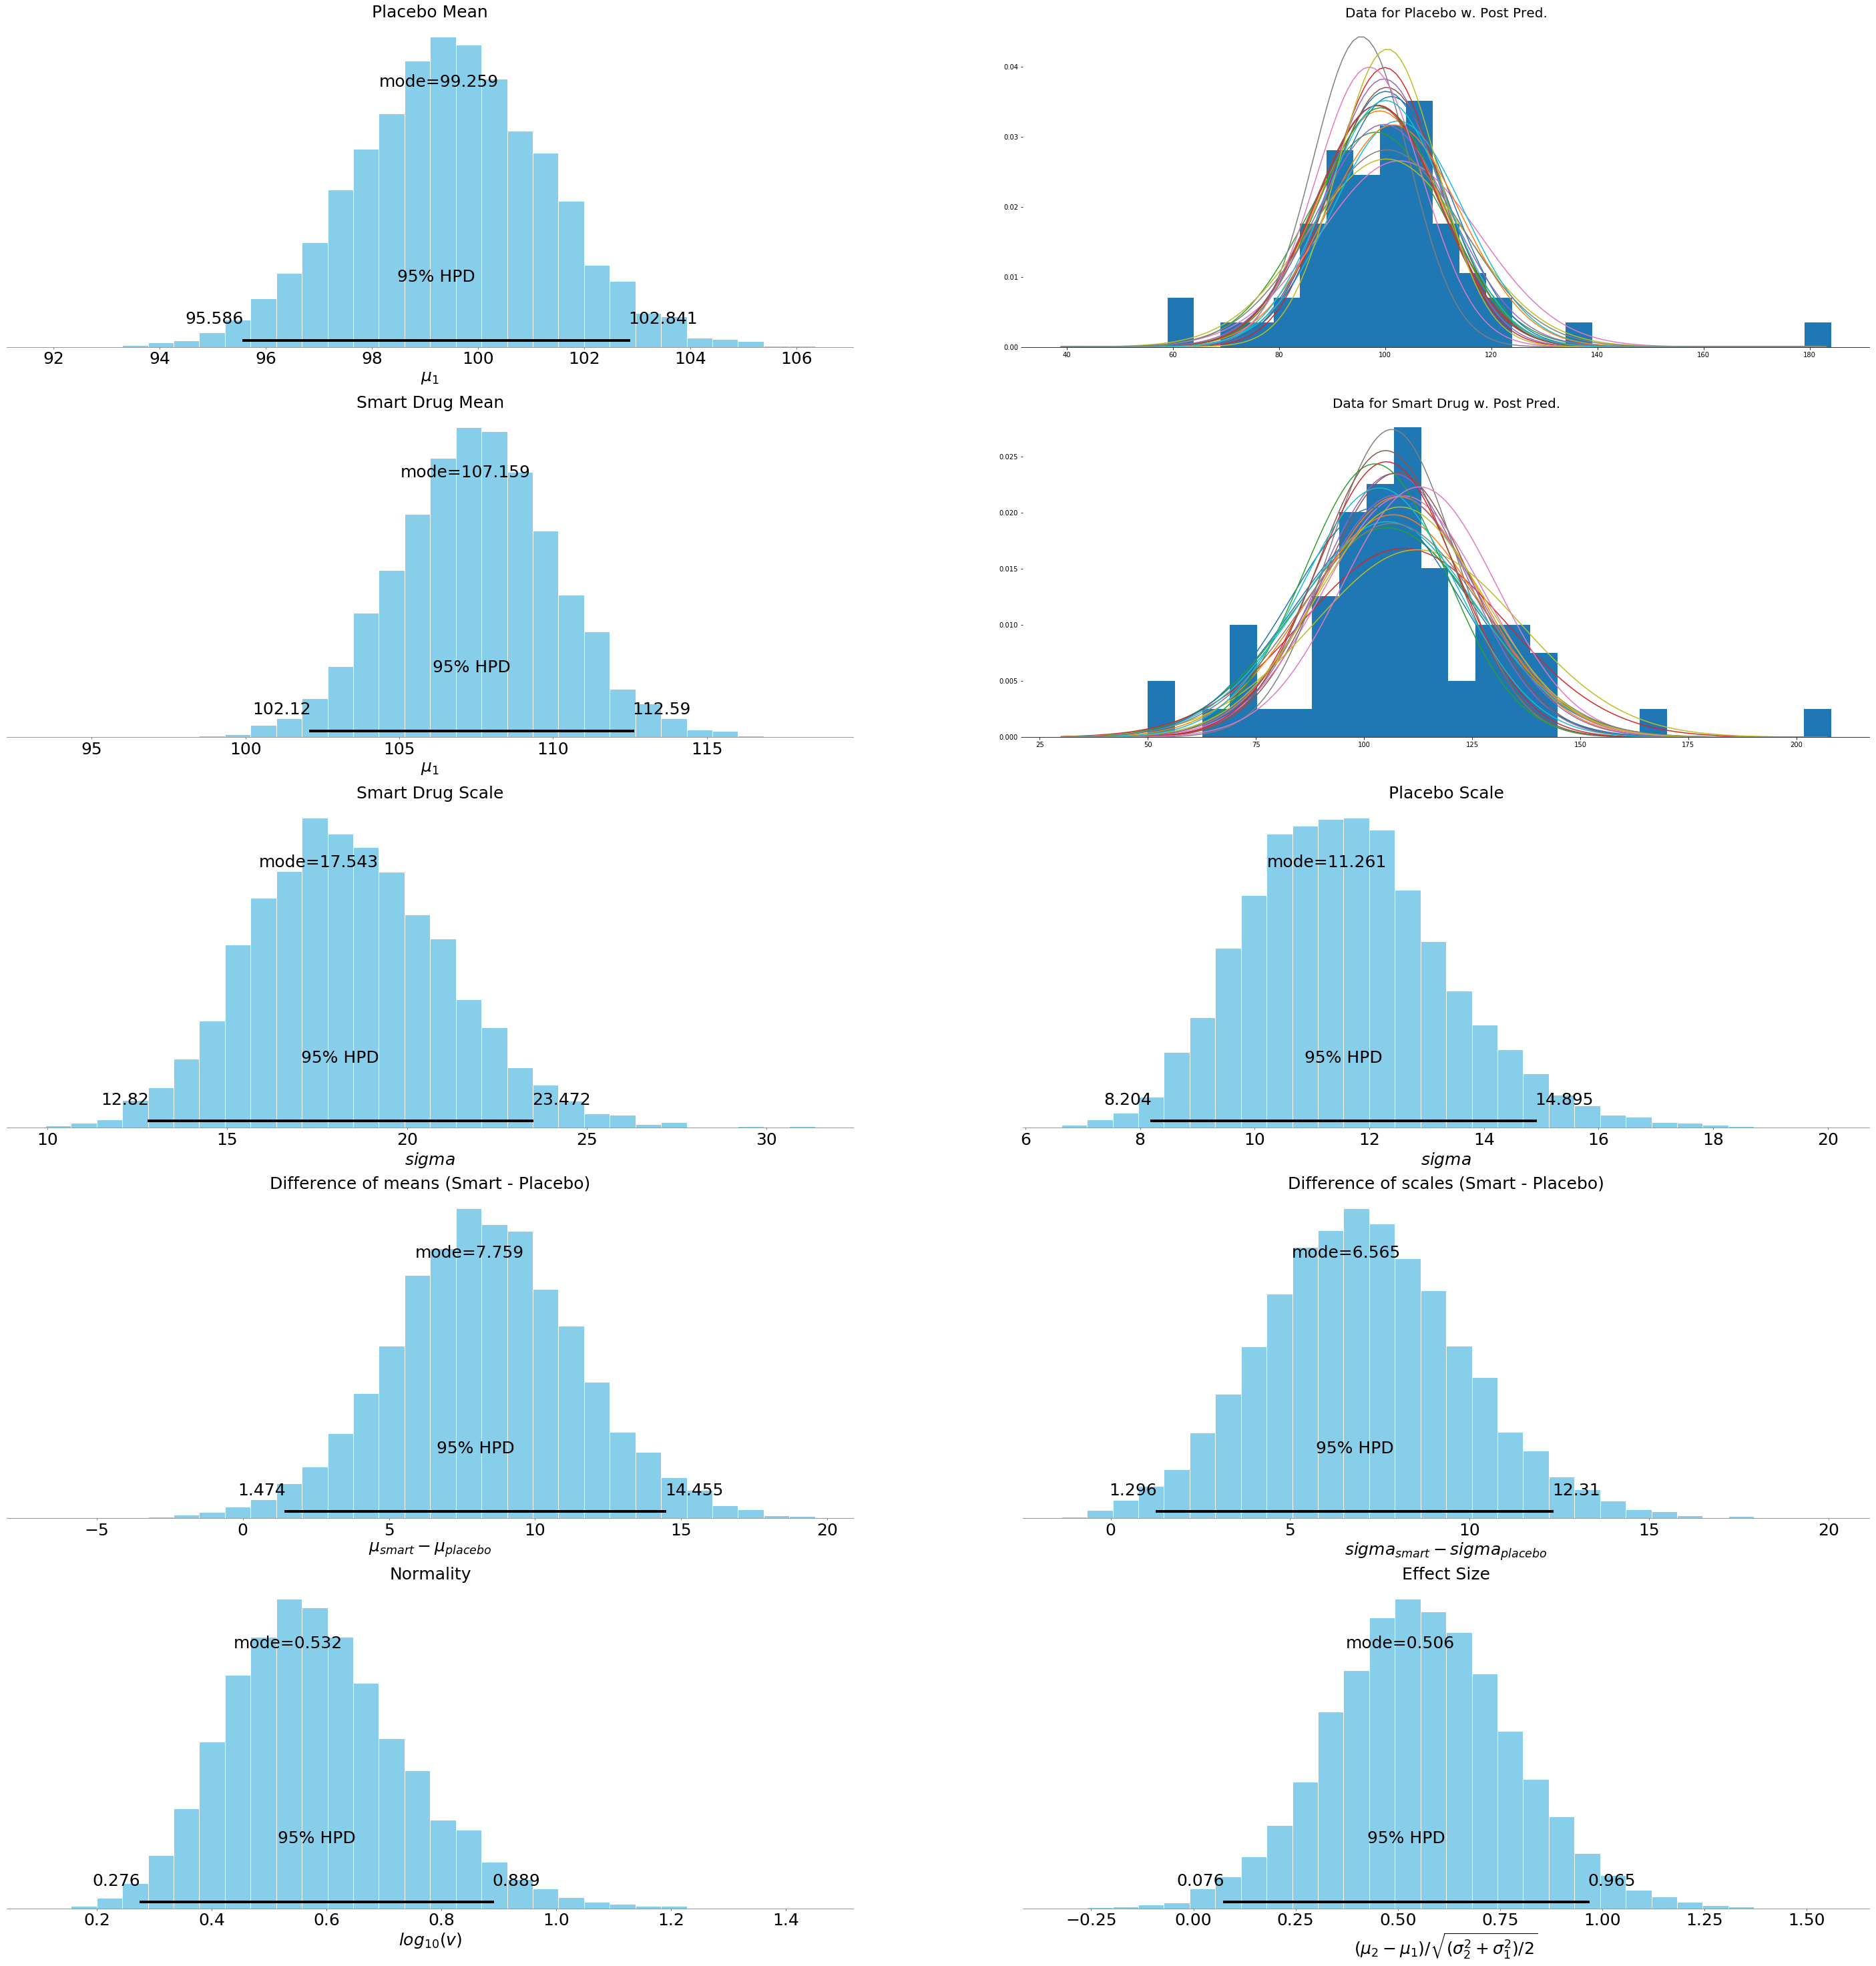

In [27]:
burned_trace = traces[7000:]
fig, [(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)] = plt.subplots(5,2, figsize=(50,52))

placebo = data["Score"][data["Group"] == "Placebo"].values
mus = burned_trace['mus'][:, 0]
sds = burned_trace['sds'][:, 0]

plot_posterior("Placebo Mean", '$\mu_1$', ax1, mus)
posterior_predictive_check(20, ax2, mu=mus, sd=sds, name="Data for Placebo w. Post Pred.", hist_data=placebo)

smart_drug = data["Score"][data["Group"] == "Smart Drug"].values
smart_drug_mu = burned_trace['mus'][:, 1]
smart_drug_sd = burned_trace['sds'][:, 1]

plot_posterior("Smart Drug Mean", '$\mu_1$', ax3, smart_drug_mu)
posterior_predictive_check(20, ax4, mu=smart_drug_mu, sd=smart_drug_sd, name="Data for Smart Drug w. Post Pred.", hist_data=smart_drug)


plot_posterior("Smart Drug Scale", '$sigma$', ax5, smart_drug_sd)
plot_posterior("Placebo Scale", '$sigma$', ax6, sds)


plot_posterior("Difference of means (Smart - Placebo)",'$\mu_{smart} - \mu_{placebo}$', ax7, smart_drug_mu - mus)
plot_posterior("Difference of scales (Smart - Placebo)",  '$sigma_{smart} - sigma_{placebo}$' , ax8, smart_drug_sd - sds)



plot_posterior("Normality",'$log_{10}(v)$', ax9, np.log10(burned_trace['nu']))


plot_posterior("Effect Size",'$(\mu_2 - \mu_1) / \sqrt{(\sigma_2^2 + \sigma_1^2) / 2  }$', ax10, (smart_drug_mu - mus) / np.sqrt( ( smart_drug_sd ** 2 + sds ** 2 ) / 2 ) )



## Exercise 16.1

In [ ]:
vars_ = ['diff_mu','diff_std', 'mus']
pm.plots.traceplot(trace=traces, varnames=vars_)

#for v in vars_:
pm.plots.plot_posterior(trace=traces['diff_mu'])
pm.plots.plot_posterior(trace=traces['diff_std'])
#pm.plots.plot_posterior(trace=traces['mus'], color=['black', 'green'])

# Helpers

In [7]:
def plot_posterior(title, x_label, axes, traces, ref_value = None):
    pm.plot_posterior(traces, point_estimate='mode', ref_val=ref_value, ax=axes, text_size=25)
    axes.set_xlabel(x_label, { 'size': 25 })
    axes.set_title(title, { 'size': 25 })

In [8]:
def posterior_predictive_check(curves, axes, mu, sd, name, hist_data):
    tr_len = len(mu)
    skip_distance = tr_len // curves
    indexes = np.arange(1, tr_len, skip_distance)
    means = mu[indexes]
    std_devs = sd[indexes]

    x = np.arange(hist_data.min() - 20, hist_data.max())
    x = np.tile(x.reshape(-1,1), (1, len(means)))
    
    posterior_estimates = scipy.stats.norm.pdf(x, means , std_devs)
    axes.plot(x, posterior_estimates)
    
    axes.hist(hist_data, density=True, bins=25)
    axes.set_title(name, {'size': 20})

    [axes.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
